In [2]:
#Import relevant Packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd
from shapely.geometry import point, polygon
import descartes
from IPython.core.display import HTML

In [3]:
#loading House_Data

df_base = pd.read_csv('kc_house_data.csv')
df_base.reset_index()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [4]:
#Data Cleaning - Removing 'id' duplicates keeping the most recent selling date
 
df_base = df_base.sort_values('date').drop_duplicates('id', keep='first')
df_base.sort_values('id', ascending = True, inplace = True)

In [5]:
#Checking for Nulls in the DataSet

df_base.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2355
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3812
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
#Null approach:

#Waterfront - removing waterfront column as it is uncorrelated to the price variable. 
#Additionally, Seattle is surounded by bodies of water where water views are not a differentiator. 

df_base = df_base.drop(['waterfront'], axis =1)

In [7]:
#Replace zero values with nan, then nan with yr_built

df_base['yr_renovated']=df_base['yr_renovated'].replace(0,np.nan)
df_base['yr_renovated'].fillna(df_base['yr_built'], inplace = True)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21416,7104100110,5/11/2015,899000.0,4,3.50,2490,5500,2.0,0.0,3,9,1780,710.0,2015,2015.0,98136,47.5499,-122.393,1710,5500
7519,9520900210,12/31/2014,614285.0,5,2.75,2730,6401,2.0,0.0,3,8,2730,0.0,2015,2015.0,98072,47.7685,-122.160,2520,6126
20472,8691440220,2/2/2015,1290000.0,5,4.00,4360,8030,2.0,0.0,3,10,4360,0.0,2015,2015.0,98075,47.5923,-121.973,3570,6185
20353,4385700250,4/7/2015,1800000.0,4,3.50,3480,4000,2.0,0.0,3,9,2460,1020.0,2015,2015.0,98112,47.6356,-122.281,2620,4000
19789,9126100765,8/1/2014,455000.0,3,1.75,1320,1014,3.0,0.0,3,9,1320,0.0,2015,2015.0,98122,47.6047,-122.305,1380,1495


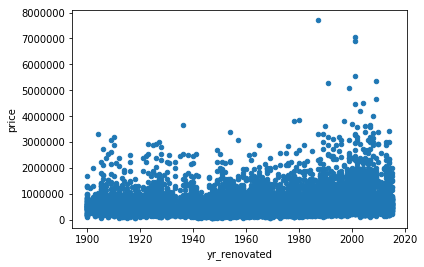

In [8]:
#Plotting the year renovated with price
df_base = df_base.sort_values('yr_renovated', ascending = False)
display(df_base.head())
df_base.plot(kind = 'scatter', x = 'yr_renovated', y = 'price')

In [9]:
#View - for the number of viewings we make an assumption that no viewings (0 value) have been made where the value is null.
#The number of nulls in view is unsignificant in the dataset (<1%)

#yr_renovated - we make the assumption here that no renovation has occured for null values in yr_renovated. 

df_base.fillna(0, inplace = True)

df_base.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21416,7104100110,5/11/2015,899000.0,4,3.50,2490,5500,2.0,0.0,3,9,1780,710.0,2015,2015.0,98136,47.5499,-122.393,1710,5500
7519,9520900210,12/31/2014,614285.0,5,2.75,2730,6401,2.0,0.0,3,8,2730,0.0,2015,2015.0,98072,47.7685,-122.160,2520,6126
20472,8691440220,2/2/2015,1290000.0,5,4.00,4360,8030,2.0,0.0,3,10,4360,0.0,2015,2015.0,98075,47.5923,-121.973,3570,6185
20353,4385700250,4/7/2015,1800000.0,4,3.50,3480,4000,2.0,0.0,3,9,2460,1020.0,2015,2015.0,98112,47.6356,-122.281,2620,4000
19789,9126100765,8/1/2014,455000.0,3,1.75,1320,1014,3.0,0.0,3,9,1320,0.0,2015,2015.0,98122,47.6047,-122.305,1380,1495


In [10]:
#Removing 'question marks' characters from dataframe 

df_base.replace({'?':np.nan}).dropna()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21416,7104100110,5/11/2015,899000.0,4,3.50,2490,5500,2.0,0.0,3,9,1780,710.0,2015,2015.0,98136,47.5499,-122.393,1710,5500
7519,9520900210,12/31/2014,614285.0,5,2.75,2730,6401,2.0,0.0,3,8,2730,0.0,2015,2015.0,98072,47.7685,-122.160,2520,6126
20472,8691440220,2/2/2015,1290000.0,5,4.00,4360,8030,2.0,0.0,3,10,4360,0.0,2015,2015.0,98075,47.5923,-121.973,3570,6185
20353,4385700250,4/7/2015,1800000.0,4,3.50,3480,4000,2.0,0.0,3,9,2460,1020.0,2015,2015.0,98112,47.6356,-122.281,2620,4000
19789,9126100765,8/1/2014,455000.0,3,1.75,1320,1014,3.0,0.0,3,9,1320,0.0,2015,2015.0,98122,47.6047,-122.305,1380,1495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231,844000425,12/23/2014,199999.0,3,1.00,960,10815,1.0,0.0,5,5,960,0.0,1900,1900.0,98010,47.3091,-122.006,1330,10815
939,2768301715,3/11/2015,565000.0,4,3.00,2020,4300,1.5,0.0,3,6,2020,0.0,1900,1900.0,98107,47.6653,-122.372,1290,3440
11522,3365900520,6/18/2014,192500.0,3,1.00,1080,8580,1.5,0.0,3,6,1080,0.0,1900,1900.0,98168,47.4716,-122.262,1800,12672
15729,9828702895,10/22/2014,700000.0,4,1.75,2420,520,1.5,0.0,3,7,2420,0.0,1900,1900.0,98112,47.6209,-122.302,1200,1170


In [11]:
#Re-checking for nulls

df_base.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

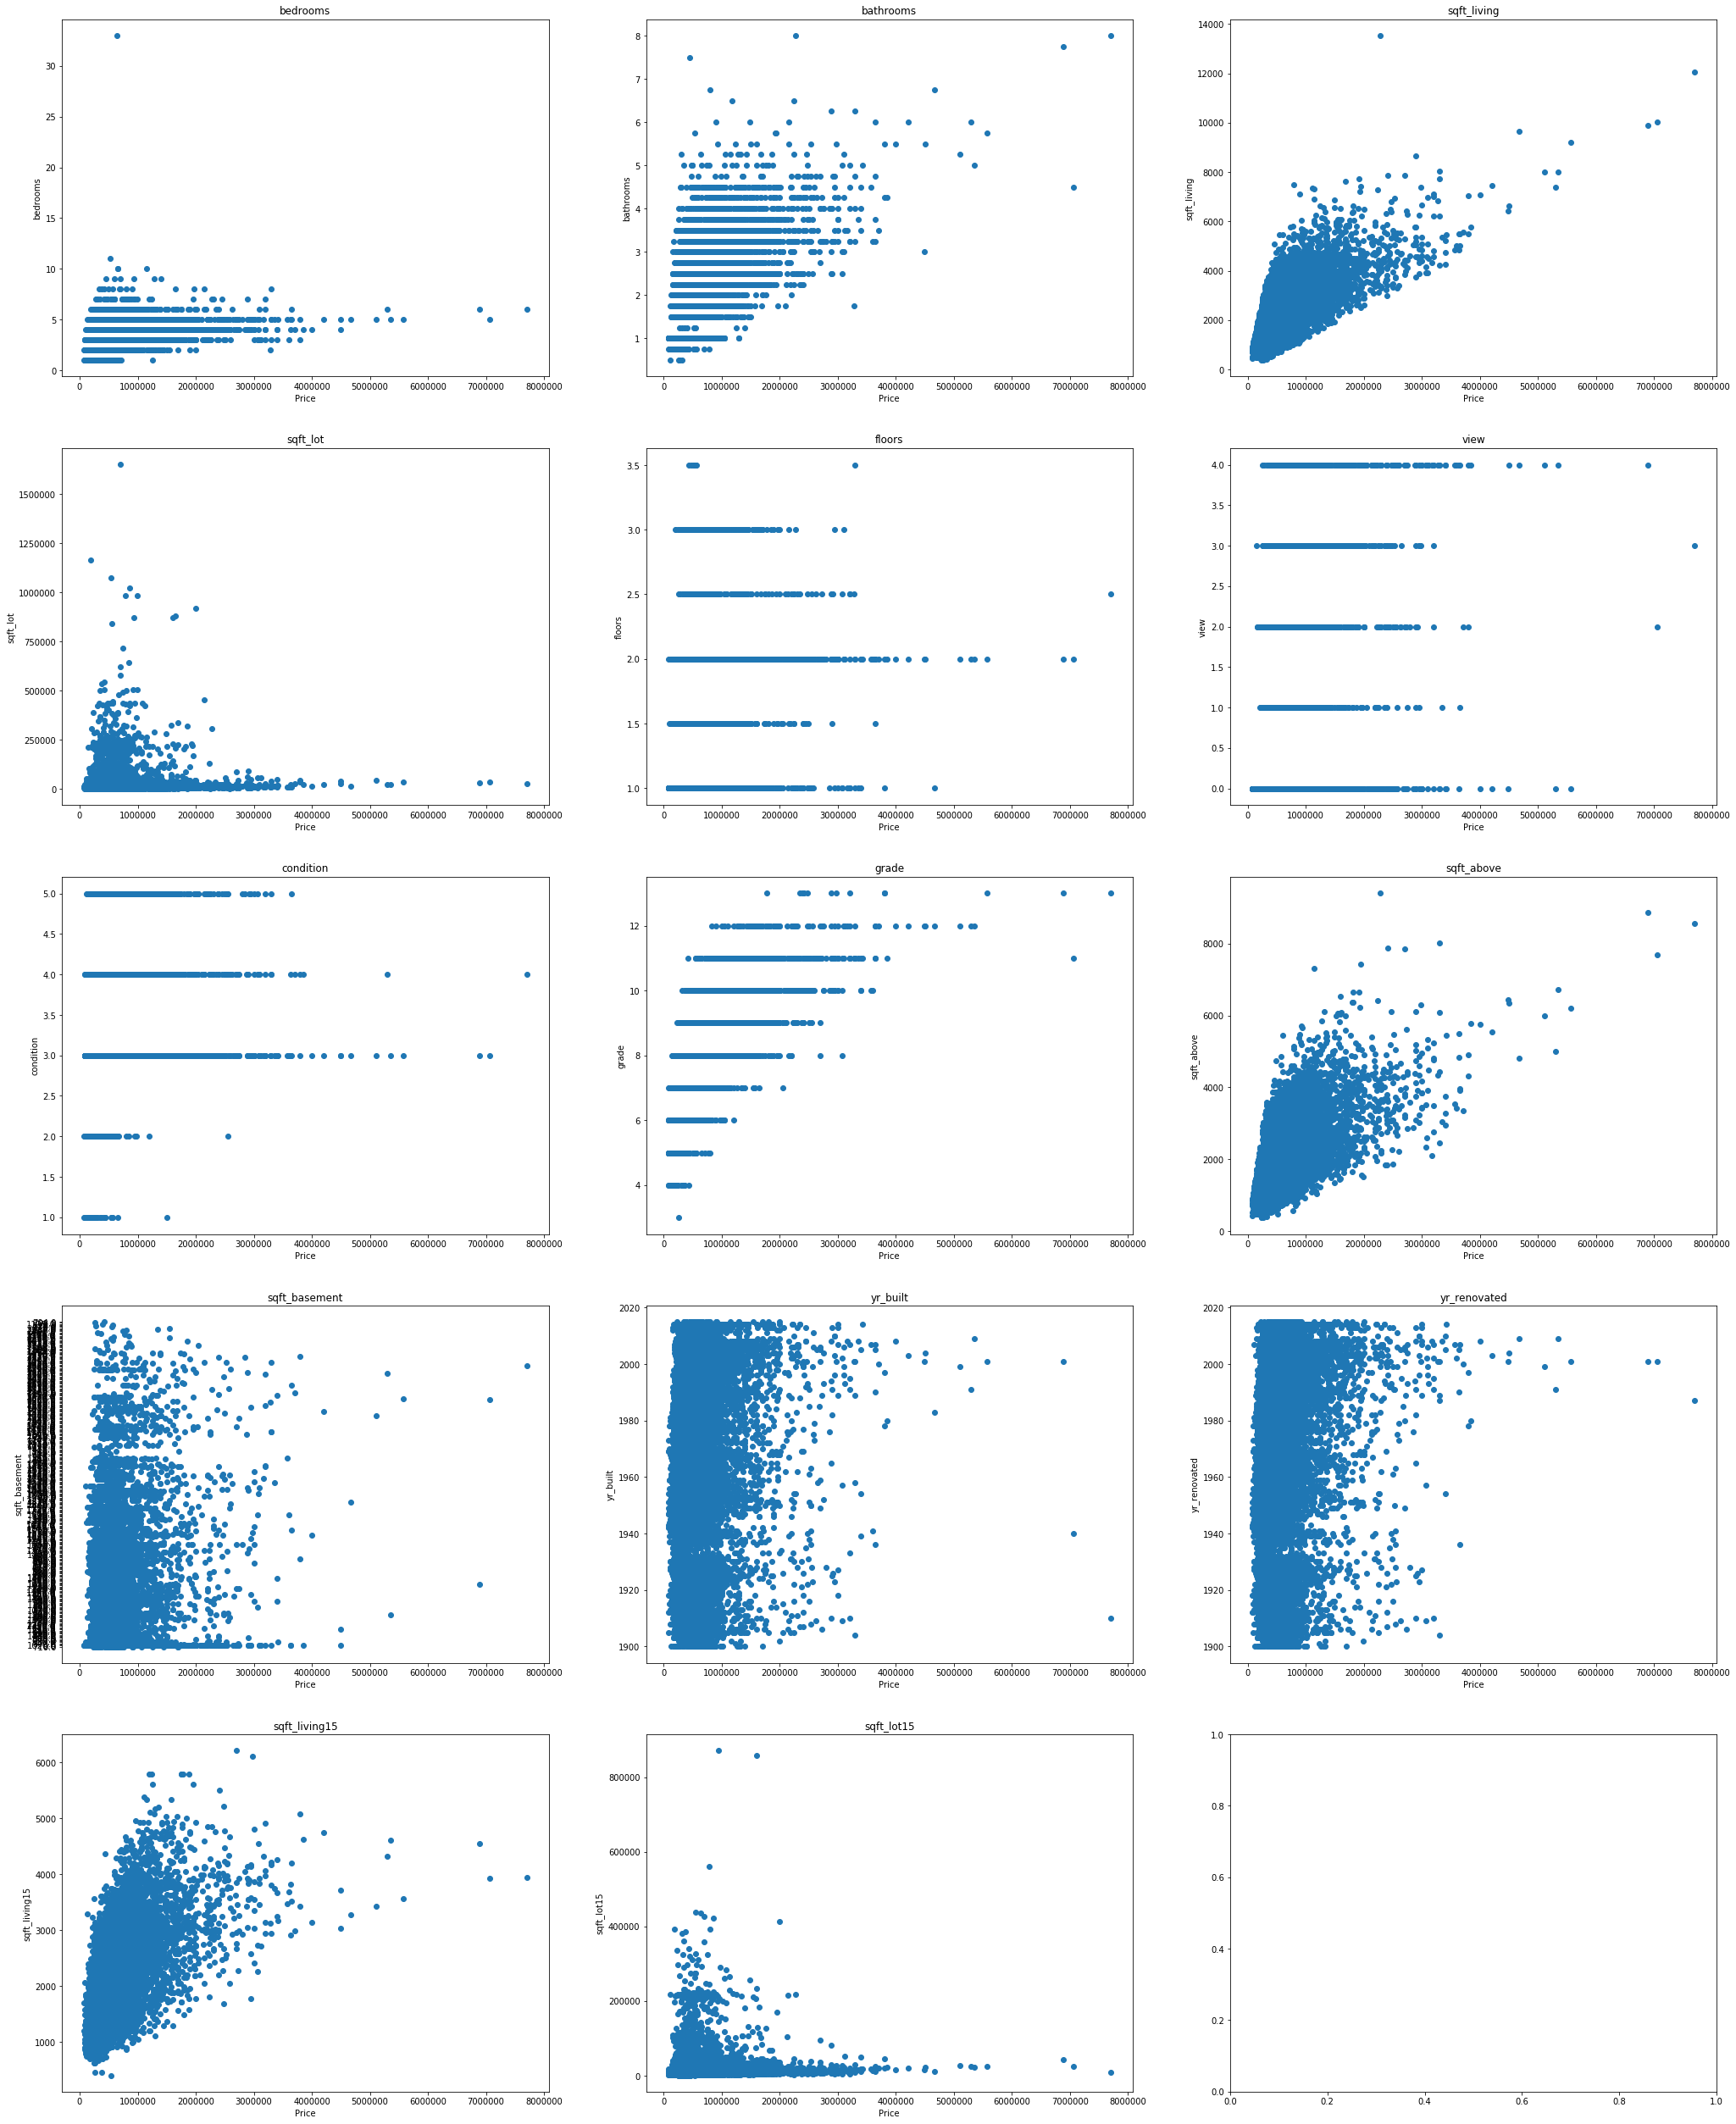

In [12]:
#Let's plot the relevant columns data against price to identify the variables we will use
Cols=['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(35,45))

for i in range(1,len(Cols)+1):
    row = (i-1)//3
    col = i%3-1
    ax = axes[row][col]
    y_new = df_base[Cols[i-1]]
    ax.scatter(df_base ['price'],y_new)
    ax.set_title(Cols[i-1])
    ax.set_xlabel('Price')
    ax.set_ylabel(Cols[i-1])

In [13]:
#Selecting our sample based the first <= fifteen houses per Zip Code

df_zip = df_base.groupby('zipcode')
df_zip = df_zip.apply(lambda x: x.sample(n=15, replace = True))

In [14]:
#Creating correlation matrix for variable 

df_zip_2 = df_zip.drop(['id','yr_built', 'yr_renovated','zipcode', 'lat','long','bathrooms'], axis = 1)
corr1 = df_zip_2.corr().round(2)
corr1.sort_values('grade', ascending = False)

,price,bedrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_living15,sqft_lot15
grade,0.67,0.35,0.77,0.03,0.50,0.16,-0.11,1.00,0.77,0.70,0.11
sqft_living,0.73,0.56,1.00,0.08,0.40,0.23,-0.05,0.77,0.88,0.75,0.17
sqft_above,0.66,0.48,0.88,0.11,0.54,0.12,-0.14,0.77,1.00,0.73,0.19
sqft_living15,0.59,0.36,0.75,0.12,0.32,0.21,-0.08,0.70,0.73,1.00,0.23
price,1.00,0.27,0.73,0.05,0.30,0.27,0.04,0.67,0.66,0.59,0.07
floors,0.30,0.21,0.40,-0.01,1.00,0.02,-0.23,0.50,0.54,0.32,0.01
bedrooms,0.27,1.00,0.56,0.02,0.21,-0.00,0.00,0.35,0.48,0.36,0.04
view,0.27,-0.00,0.23,0.14,0.02,1.00,0.09,0.16,0.12,0.21,0.12
sqft_lot15,0.07,0.04,0.17,0.79,0.01,0.12,0.01,0.11,0.19,0.23,1.00
sqft_lot,0.05,0.02,0.08,1.00,-0.01,0.14,0.03,0.03,0.11,0.12,0.79


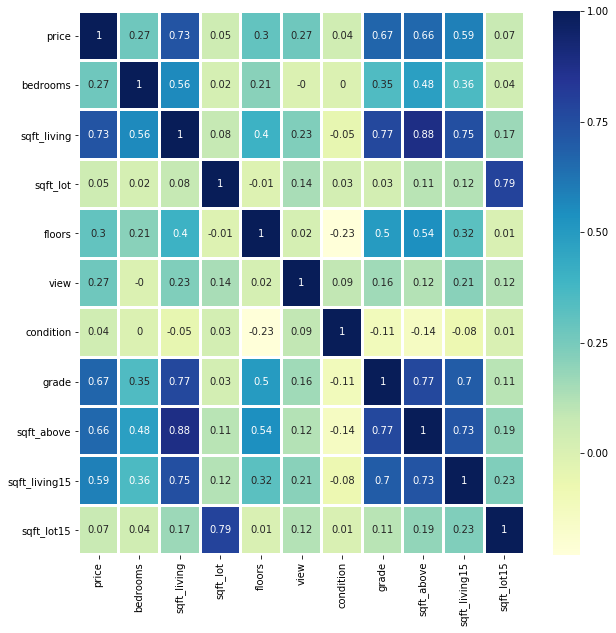

In [15]:
#Correlation heatmap and variable selection

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data = corr1, annot = True, annot_kws = {"size": 10}, linewidth = 2, cmap="YlGnBu")

In [16]:
#Setting up variables for statistical analysis 
#This is the first model we will test without applying an outlier removal process. 

X = df_base [['sqft_living', 'grade']]
Y = df_base ['price']

In [17]:
# Setting up the LEARNER
X = sm.add_constant(X)
model_sm = sm.OLS(Y,X)

#Learning
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))
results.summary()

R2 = 0.53
const         -602114.3920
sqft_living       184.2716
grade           99151.4191
dtype: float64


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                 1.226e+04
Date:                Tue, 21 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:13:36   Log-Likelihood:            -2.9671e+05
No. Observations:               21420   AIC:                         5.934e+05
Df Residuals:                   21417   BIC:                         5.935e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.021e+05   1.34e+04    -44.797      0.000   -6.28e+05   -5.76e+05
sqft_living   184.2716      2.885     63.864      0.000     178.616     189.927
grade        9.915e+04   2262.110     43.831      0.000    9.47e+04    1.04e+05
==============================================================================
Omnibus:                    16826.521   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           997237.116
Skew:                           3.305   Prob(JB):                         0.00
Kurtosis:                      35.767   Cond. No.                     1.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
#Part1_Mode2: sqft living outlier removal using standard deviation 


#Create column with std deviation for sqft_living variable 
df_base['sqft_living_std'] = df_base['sqft_living'].std()

#Create column with how many std deviation away from the mean each value for sqft living is
df_base['outlier_sqft'] = (df_base ['sqft_living'] - df_base['sqft_living'].mean())/df_base['sqft_living_std']

df_base.drop( df_base.loc[df_base.outlier_sqft > 2]. index, inplace = True )#drop values higher than 2 std deviation of mean
df_base.drop( df_base.loc[df_base.outlier_sqft < -2]. index, inplace = True) #keep values greater than -2 std deviation of mean 
df_base.sort_values('outlier_sqft', ascending = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_std,outlier_sqft
15390,4401200460,10/20/2014,813000.0,4,2.50,3430,7508,2.0,0.0,3,...,0.0,1998,1998.0,98052,47.6866,-122.110,3110,8741,733.578585,1.986662
3758,2523089097,10/29/2014,524500.0,3,1.50,3430,264844,1.0,2.0,3,...,1200.0,1988,1988.0,98045,47.4476,-121.723,1660,145926,733.578585,1.986662
10653,7852160310,8/14/2014,1010000.0,4,2.75,3430,15877,1.0,4.0,3,...,0.0,2005,2005.0,98065,47.5364,-121.856,4080,14577,733.578585,1.986662
20154,6626300095,5/19/2014,749950.0,4,2.50,3430,64441,2.0,0.0,3,...,0.0,2013,2013.0,98077,47.7694,-122.064,3580,64441,733.578585,1.986662
19668,1973700030,4/29/2015,2210000.0,3,2.50,3430,10177,2.0,0.0,3,...,0.0,2014,2014.0,98034,47.7159,-122.251,3110,12339,733.578585,1.986662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,2420069251,2/25/2015,262000.0,1,0.75,520,12981,1.0,0.0,5,...,0.0,1920,1920.0,98022,47.2082,-121.995,1340,12233,733.578585,-1.980193
2139,1623049041,5/8/2014,82500.0,2,1.00,520,22334,1.0,0.0,2,...,0.0,1951,1951.0,98168,47.4799,-122.296,1572,10570,733.578585,-1.980193
18045,1773101530,12/18/2014,275000.0,1,1.00,520,4800,1.0,0.0,3,...,0.0,1930,1930.0,98106,47.5533,-122.363,800,4960,733.578585,-1.980193
6773,7588700177,4/20/2015,310000.0,1,0.75,520,2885,1.0,0.0,4,...,0.0,1947,1947.0,98117,47.6886,-122.378,980,4241,733.578585,-1.980193


In [20]:
#grading outlier removal using standard deviation


#Create column with std deviation for grading variable 
df_base['grade_std'] = df_base['grade'].std()

#Create column with how many std deviation away from the mean each value for sqft living is
df_base['outlier_grade'] = (df_base ['grade'] - df_base['grade'].mean())/df_base['grade_std']

df_base.drop( df_base.loc[df_base.outlier_grade > 2]. index, inplace = True )#drop values higher than 2 std deviation of mean
df_base.drop( df_base.loc[df_base.outlier_grade < -2]. index, inplace = True) #keep values greater than -2 std deviation of mean 
df_base.sort_values('outlier_grade', ascending = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_std,outlier_sqft,grade_std,outlier_grade
21416,7104100110,5/11/2015,899000.0,4,3.50,2490,5500,2.0,0.0,3,...,2015.0,98136,47.5499,-122.393,1710,5500,733.578585,0.705273,0.97741,1.550575
4535,3223069118,6/16/2014,554000.0,3,3.50,3380,108900,2.0,0.0,3,...,1999.0,98058,47.4316,-122.075,2250,130680,733.578585,1.918503,0.97741,1.550575
9186,7935000625,4/9/2015,975000.0,3,2.50,2530,7000,2.5,4.0,3,...,1999.0,98136,47.5465,-122.398,2380,7000,733.578585,0.759800,0.97741,1.550575
7399,2385200050,6/20/2014,425000.0,3,2.50,2540,5612,2.0,0.0,3,...,1999.0,98059,47.4965,-122.157,2380,6303,733.578585,0.773432,0.97741,1.550575
17400,1825079005,6/9/2014,739000.0,4,2.50,2800,246114,2.0,0.0,3,...,1999.0,98014,47.6586,-121.962,2750,60351,733.578585,1.127859,0.97741,1.550575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15235,9357000635,3/23/2015,345000.0,3,1.00,1060,5600,1.0,0.0,4,...,1943.0,98146,47.5116,-122.379,1310,5600,733.578585,-1.244075,0.97741,-1.518760
16222,3365901435,6/23/2014,165000.0,3,1.00,1200,13100,1.0,0.0,3,...,1943.0,98168,47.4750,-122.258,1960,11285,733.578585,-1.053230,0.97741,-1.518760
14556,8122100905,6/24/2014,395000.0,4,1.75,1540,5120,1.0,0.0,5,...,1943.0,98126,47.5359,-122.372,1080,5120,733.578585,-0.589749,0.97741,-1.518760
15937,9900000190,10/30/2014,268950.0,3,1.00,1320,8100,1.0,0.0,3,...,1943.0,98166,47.4697,-122.351,1000,8100,733.578585,-0.889649,0.97741,-1.518760


In [22]:
#Removing columns that are not needed anymore. 

df_base.drop(['outlier_sqft', 'grade_std','outlier_grade'],axis=1, inplace= True)

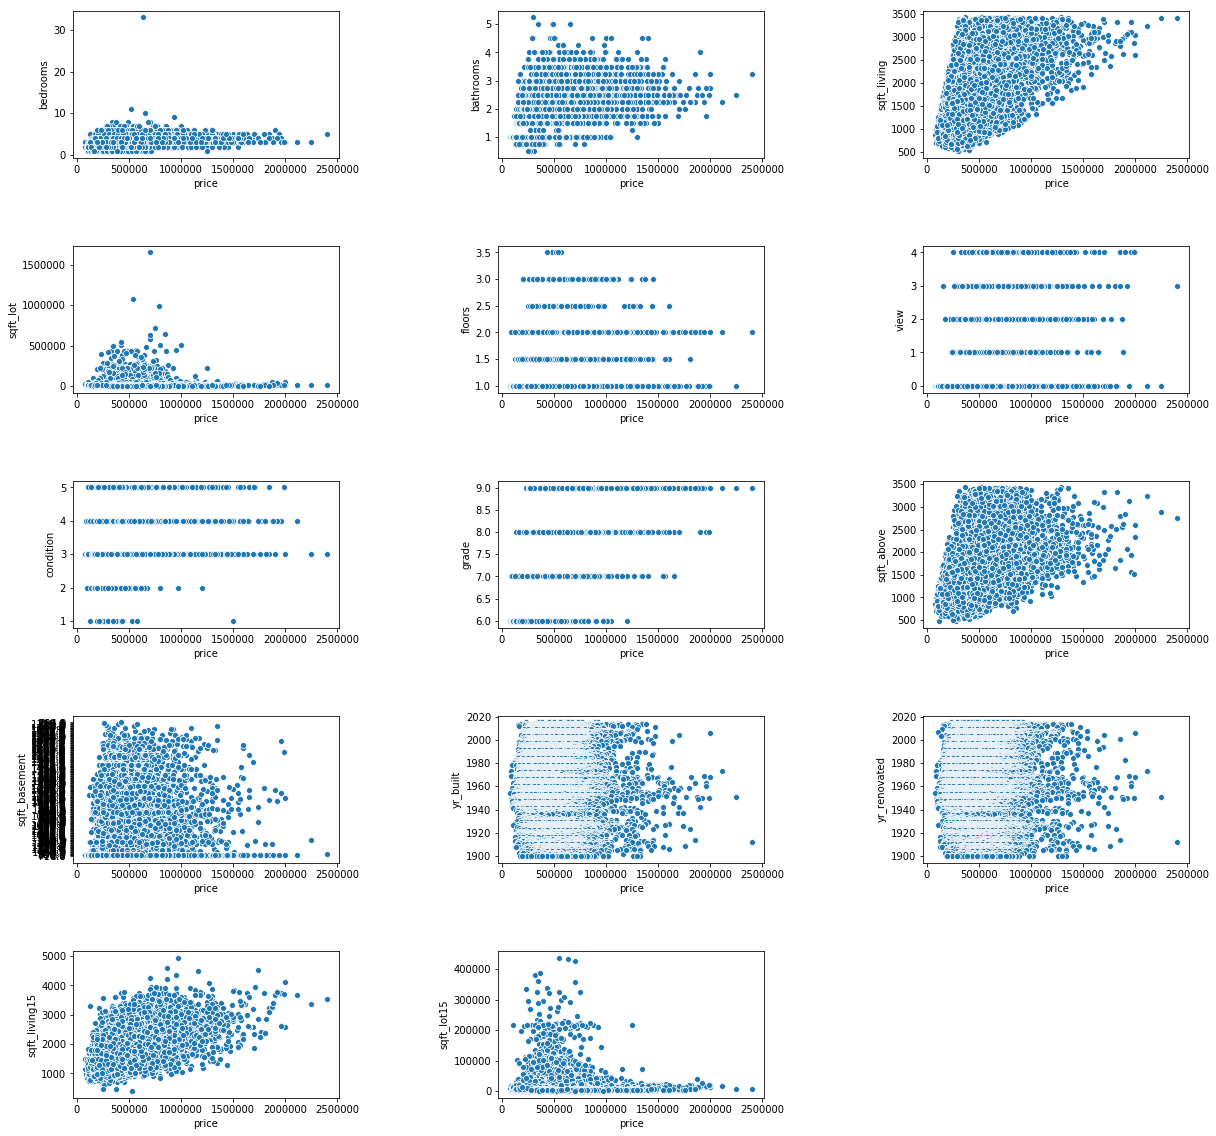

In [24]:
#Data Vizualization to check variables after outliers have been removed and use seaborn as a new display tool

plt.figure(figsize=(20,20))

for i, col in enumerate(Cols):
    plt.subplot(5, 3, i+1)
    sns.scatterplot(x="price", y= col, data= df_base)
    plt.subplots_adjust(wspace=0.6, hspace=0.6)

In [25]:
#Creating the sample for the second model (post outlier removal)

df_zip= df_base.groupby('zipcode')
df_zip = df_zip.apply(lambda x: x.sample(n=15, replace = True))
display(df_zip.head())
display(df_zip.shape)

id        date     price  bedrooms  bathrooms  \
zipcode                                                                
98001   5152   5556900080   9/26/2014  169000.0         3       1.00   
        15857  3750604417   5/26/2014  172500.0         3       1.00   
        15776  1311800130   1/23/2015  162500.0         3       1.50   
        16782  5530000050  10/27/2014  278000.0         3       1.75   
        7300    255580190   9/15/2014  302000.0         4       2.50   

               sqft_living  sqft_lot  floors  view  condition  ...  \
zipcode                                                        ...   
98001   5152           910      7686     1.0   0.0          3  ...   
        15857         1140      8800     1.0   0.0          3  ...   
        15776         1390      7417     1.0   0.0          3  ...   
        16782         2710      9088     1.0   0.0          4  ...   
        7300          1740      7895     2.0   0.0          3  ...   

               sqft_above  sqft_basement yr_built  yr_renovated  zipcode  \
zipcode                                                                    
98001   5152          910            0.0     1969        1969.0    98001   
        15857        1140            0.0     1972        1972.0    98001   
        15776        1390            0.0     1967        1967.0    98001   
        16782        2060          650.0     1965        1965.0    98001   
        7300         1740            0.0     1999        1999.0    98001   

                   lat     long  sqft_living15  sqft_lot15  sqft_living_std  
zipcode                                                                      
98001   5152   47.3405 -122.288           1020        7686       733.578585  
        15857  47.2629 -122.275           1270       13560       733.578585  
        15776  47.3369 -122.275           1390        7665       733.578585  
        16782  47.3073 -122.272           1690       10454       733.578585  
        7300   47.3401 -122.282           1720        6813       733.578585  

[5 rows x 21 columns]

(1050, 21)

In [27]:
#Additional column removal to simplify correlation matrix

new_df_zip=df_zip.drop(['id','date','sqft_lot', 'view', 'condition','sqft_above'],axis=1)
new_df_zip=df_zip.drop(['id','date','sqft_lot', 'view', 'condition','sqft_above'],axis=1)
display(new_df_zip.columns)
new_df_zip.drop(['sqft_basement', 'yr_renovated', 'zipcode', 'sqft_lot15'],axis=1, inplace= True)

#Building new correlation table with outliers removed from variables

display(new_df_zip.head())
corr_df = new_df_zip.corr().round(2)
corr_df.sort_values('sqft_living', ascending = False)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqft_living_std'],
      dtype='object')

price  bedrooms  bathrooms  sqft_living  floors  grade  \
zipcode                                                                    
98001   5152   169000.0         3       1.00          910     1.0      7   
        15857  172500.0         3       1.00         1140     1.0      7   
        15776  162500.0         3       1.50         1390     1.0      7   
        16782  278000.0         3       1.75         2710     1.0      7   
        7300   302000.0         4       2.50         1740     2.0      7   

               yr_built      lat     long  sqft_living15  sqft_living_std  
zipcode                                                                    
98001   5152       1969  47.3405 -122.288           1020       733.578585  
        15857      1972  47.2629 -122.275           1270       733.578585  
        15776      1967  47.3369 -122.275           1390       733.578585  
        16782      1965  47.3073 -122.272           1690       733.578585  
        7300       1999  47.3401 -122.282           1720       733.578585

,price,bedrooms,bathrooms,sqft_living,floors,grade,yr_built,lat,long,sqft_living15,sqft_living_std
sqft_living,0.56,0.57,0.67,1.00,0.29,0.64,0.23,0.09,0.17,0.68,-0.0
sqft_living15,0.56,0.33,0.48,0.68,0.23,0.60,0.22,0.10,0.22,1.00,-0.0
bathrooms,0.38,0.45,1.00,0.67,0.49,0.59,0.48,0.06,0.15,0.48,0.0
grade,0.59,0.24,0.59,0.64,0.47,1.00,0.41,0.15,0.13,0.60,-0.0
bedrooms,0.27,1.00,0.45,0.57,0.14,0.24,0.08,0.00,0.06,0.33,-0.0
price,1.00,0.27,0.38,0.56,0.23,0.59,-0.08,0.41,-0.06,0.56,-0.0
floors,0.23,0.14,0.49,0.29,1.00,0.47,0.45,0.09,0.04,0.23,0.0
yr_built,-0.08,0.08,0.48,0.23,0.45,0.41,1.00,-0.10,0.37,0.22,-0.0
long,-0.06,0.06,0.15,0.17,0.04,0.13,0.37,-0.07,1.00,0.22,0.0
lat,0.41,0.00,0.06,0.09,0.09,0.15,-0.10,1.00,-0.07,0.10,-0.0


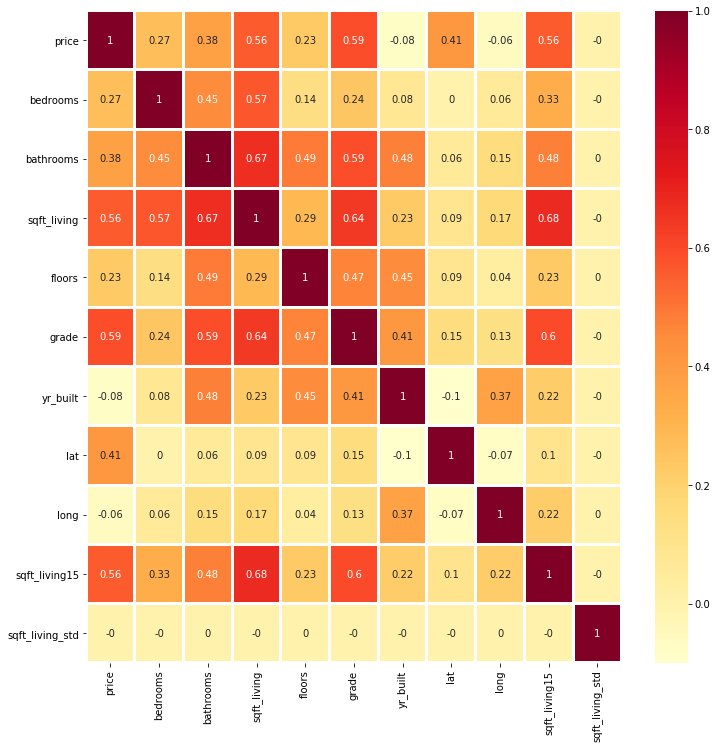

In [29]:
#Correlation matrix display with new data 

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(data = corr_df, annot = True, linewidth = 2, cmap= "YlOrRd")
plt.show()

In [31]:
#Setting up variables for statistical analysis 

X = corr_df[['sqft_living', 'grade']]
Y = corr_df['price']

In [32]:
# Setting up the LEARNER
X = sm.add_constant(X)
model_sm = sm.OLS(Y,X)

#Learning
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))
results.summary()

R2 = 0.46
const         -0.0003
sqft_living    0.3916
grade          0.4034
dtype: float64


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     3.437
Date:                Tue, 21 Jan 2020   Prob (F-statistic):             0.0837
Time:                        11:21:36   Log-Likelihood:                0.62346
No. Observations:                  11   AIC:                             4.753
Df Residuals:                       8   BIC:                             5.947
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.157     -0.002      0.998      -0.362       0.361
sqft_living     0.3916      0.415      0.943      0.373      -0.566       1.349
grade           0.4034      0.442      0.913      0.388      -0.616       1.422
==============================================================================
Omnibus:                        5.819   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                2.437
Skew:                           1.101   Prob(JB):                        0.296
Kurtosis:                       3.682   Cond. No.                         8.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""